# Influence of the batch-size on the approximated posteriors

In [1]:
import hypothesis
import numpy as np
import glob
import matplotlib
import plotting
import matplotlib.pyplot as plt
import torch

from hypothesis.stat import highest_density_level
from hypothesis.visualization.util import make_square
from matplotlib.colors import LogNorm
from matplotlib import rc
from plotting import compute_1d_pdf
from plotting import compute_2d_pdf
from plotting import compute_1d_pdf_abc
from plotting import compute_2d_pdf_abc
from plotting import plot_1d_pdf
from plotting import plot_2d_pdf
from plotting import plot_1d_pdf_std
from plotting import plot_1d_contours
from plotting import plot_2d_contours
from plotting import plot_stream
from tqdm import tqdm
from util import load_ratio_estimator
from util import MarginalizedAgePrior

In [2]:
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amssymb}"

# Matplotlib settings
plt.rcParams.update({"font.size": 18})
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rcParams["text.usetex"] = True

In [3]:
!mkdir -p plots

## Load the pretrained ratio estimators

In [4]:
activation = "selu"

In [5]:
query = "out/batch-size/4096/marginalized/" + activation + "/*mlp-50-*batchnorm-1*/best-model.th"
r_4096 = load_ratio_estimator(query, normalize_inputs=False)

In [6]:
query = "out/batch-size/1024/marginalized/" + activation + "/*mlp-50-*batchnorm-1*/best-model.th"
r_1024 = load_ratio_estimator(query, normalize_inputs=False)

In [7]:
query = "out/batch-size/256/marginalized/" + activation + "/*mlp-50-*batchnorm-1*/best-model.th"
r_256 = load_ratio_estimator(query, normalize_inputs=False)

In [8]:
query = "out/batch-size/64/marginalized/" + activation + "/*mlp-50-*batchnorm-1*/best-model.th"
r_64 = load_ratio_estimator(query, normalize_inputs=False)

## Globals

In [9]:
datadir = "../experiment-simulations/data"   # Root directory containing the generated and observed data
phi = np.load(datadir + "/phi-cut.npy")      # Linear angle
ages = np.load(datadir + "/test/ages.npy")
masses = np.load(datadir + "/test/masses.npy")
streams = np.load(datadir + "/test/density-contrasts-cut-noised.npy")
prior = MarginalizedAgePrior()

## Losses with respect to batch-size

In [10]:
query = "out/batch-size/4096/marginalized/" + activation + "/*mlp-50-*batchnorm-1*/losses-test.npy"
paths = glob.glob(query)
data = []
for path in paths:
    data.append(np.load(path).reshape(1, -1))
    
losses_4096 = np.vstack(data)

In [11]:
query = "out/batch-size/1024/marginalized/" + activation + "/*mlp-50-*batchnorm-1*/losses-test.npy"
paths = glob.glob(query)
data = []
for path in paths:
    data.append(np.load(path).reshape(1, -1))
    
losses_1024 = np.vstack(data)

In [12]:
query = "out/batch-size/256/marginalized/" + activation + "/*mlp-50-*batchnorm-1*/losses-test.npy"
paths = glob.glob(query)
data = []
for path in paths:
    data.append(np.load(path).reshape(1, -1))
    
losses_256 = np.vstack(data)

In [13]:
query = "out/batch-size/64/marginalized/" + activation + "/*mlp-50-*batchnorm-1*/losses-test.npy"
paths = glob.glob(query)
data = []
for path in paths:
    data.append(np.load(path).reshape(1, -1))
    
losses_64 = np.vstack(data)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


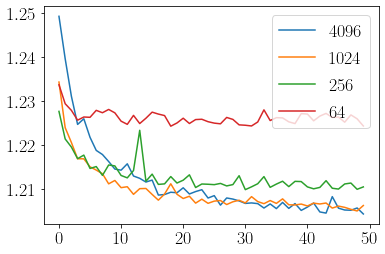

In [14]:
epochs = np.arange(1, 50 + 1)

plt.plot(np.mean(losses_4096, axis=0), label="4096")
plt.plot(np.mean(losses_1024, axis=0), label="1024")
plt.plot(np.mean(losses_256, axis=0), label="256")
plt.plot(np.mean(losses_64, axis=0), label="64")
plt.legend()
plt.show()

In [15]:
test_losses_m = [
    np.mean(losses_64, axis=0),
    np.mean(losses_256, axis=0),
    np.mean(losses_1024, axis=0),
    np.mean(losses_4096, axis=0)
]

test_losses_e = [
    np.std(losses_64, axis=0),
    np.std(losses_256, axis=0),
    np.std(losses_1024, axis=0),
    np.std(losses_4096, axis=0)
]

### Verify 95% CR coverage

In [16]:
def fetch_coverage(batch_size):
    # Fetch the results
    level = 0.95
    query = "out/batch-size/" + str(batch_size) + "/marginalized/selu/*" + str(level) + "*.npy"
    paths = glob.glob(query)
    coverages = []
    for path in paths:
        result = np.load(path)
        coverages.append(result.sum() / len(result))
    if len(coverages) == 0:
        raise ValueError("No results available!")
    coverages = np.array(coverages)
    m = round(np.mean(coverages), 3)
    s = round(np.std(coverages), 3)

    return m, s

#### Batch-size 64

In [17]:
fetch_coverage(64)

(0.961, 0.004)

#### Batch-size 256

In [18]:
fetch_coverage(256)

(0.954, 0.004)

#### Batch-size 1024

In [19]:
fetch_coverage(1024)

(0.952, 0.008)

#### Batch-size 4096

In [20]:
fetch_coverage(4096)

(0.952, 0.006)

#### Summary

In [21]:
cov_64_m, cov_64_s = fetch_coverage(64)
cov_256_m, cov_256_s = fetch_coverage(256)
cov_1024_m, cov_1024_s = fetch_coverage(1024)
cov_4096_m, cov_4096_s = fetch_coverage(4096)

## Compute $\mathbb{E}_{x\sim p(x)}\left[\log p(\vartheta = \vartheta^*\vert x\right]$ for the various settings

In [22]:
def expected_nominal_pdf(r, n=1000):
    estimates = []
    for _ in range(n):
        index = np.random.randint(0, 100000)
        stream = torch.from_numpy(streams[index]).unsqueeze(0).float()
        mass = torch.from_numpy(masses[index]).unsqueeze(0).float()
        stream = stream.to(hypothesis.accelerator)
        mass = mass.to(hypothesis.accelerator)
        log_pdf = prior.log_prob(mass) + r.log_ratio(inputs=mass, outputs=stream)
        estimates.append(log_pdf.item())
        
    return np.mean(estimates)

In [23]:
repeat = 25 # Repeat the experiments 25 times

In [24]:
estimates = []
for _ in tqdm(range(repeat)):
    estimates.append(expected_nominal_pdf(r_4096))
print(np.mean(estimates), "±", np.std(estimates))

m_4096 = np.mean(estimates)
s_4096 = np.std(estimates)

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:01<00:32,  1.37s/it]

  8%|▊         | 2/25 [00:02<00:31,  1.36s/it]

 12%|█▏        | 3/25 [00:04<00:30,  1.36s/it]

 16%|█▌        | 4/25 [00:05<00:28,  1.36s/it]

 20%|██        | 5/25 [00:06<00:27,  1.36s/it]

 24%|██▍       | 6/25 [00:08<00:25,  1.36s/it]

 28%|██▊       | 7/25 [00:09<00:24,  1.36s/it]

 32%|███▏      | 8/25 [00:10<00:23,  1.36s/it]

 36%|███▌      | 9/25 [00:12<00:21,  1.36s/it]

 40%|████      | 10/25 [00:13<00:20,  1.36s/it]

 44%|████▍     | 11/25 [00:14<00:19,  1.36s/it]

 48%|████▊     | 12/25 [00:16<00:17,  1.36s/it]

 52%|█████▏    | 13/25 [00:17<00:16,  1.36s/it]

 56%|█████▌    | 14/25 [00:19<00:15,  1.36s/it]

 60%|██████    | 15/25 [00:20<00:13,  1.36s/it]

 64%|██████▍   | 16/25 [00:21<00:12,  1.36s/it]

 68%|██████▊   | 17/25 [00:23<00:10,  1.36s/it]

 72%|███████▏  | 18/25 [00:24<00:09,  1.36s/it]

 76%|███████▌  | 19/25 [00:25<00:08,  1.36s/it]

 80%|████████  | 20/25 [00:27<00:06,  1.36s/it]

 84%|████████▍ | 21/25 [00:28<00:05,  1.36s/it]

 88%|████████▊ | 22/25 [00:30<00:04,  1.36s/it]

 92%|█████████▏| 23/25 [00:31<00:02,  1.36s/it]

 96%|█████████▌| 24/25 [00:32<00:01,  1.36s/it]

100%|██████████| 25/25 [00:34<00:00,  1.36s/it]

100%|██████████| 25/25 [00:34<00:00,  1.36s/it]

-3.5127728618335725 ± 0.019378810244491097


In [25]:
m_4096

-3.5127728618335725

In [26]:
estimates = []
for _ in tqdm(range(repeat)):
    estimates.append(expected_nominal_pdf(r_1024))
print(np.mean(estimates), "±", np.std(estimates))

m_1024 = np.mean(estimates)
s_1024 = np.std(estimates)

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:01<00:32,  1.36s/it]

  8%|▊         | 2/25 [00:02<00:31,  1.36s/it]

 12%|█▏        | 3/25 [00:04<00:29,  1.36s/it]

 16%|█▌        | 4/25 [00:05<00:28,  1.36s/it]

 20%|██        | 5/25 [00:06<00:27,  1.36s/it]

 24%|██▍       | 6/25 [00:08<00:25,  1.36s/it]

 28%|██▊       | 7/25 [00:09<00:24,  1.36s/it]

 32%|███▏      | 8/25 [00:10<00:23,  1.36s/it]

 36%|███▌      | 9/25 [00:12<00:21,  1.36s/it]

 40%|████      | 10/25 [00:13<00:20,  1.36s/it]

 44%|████▍     | 11/25 [00:15<00:19,  1.36s/it]

 48%|████▊     | 12/25 [00:16<00:17,  1.36s/it]

 52%|█████▏    | 13/25 [00:17<00:16,  1.36s/it]

 56%|█████▌    | 14/25 [00:19<00:15,  1.36s/it]

 60%|██████    | 15/25 [00:20<00:13,  1.36s/it]

 64%|██████▍   | 16/25 [00:21<00:12,  1.36s/it]

 68%|██████▊   | 17/25 [00:23<00:10,  1.36s/it]

 72%|███████▏  | 18/25 [00:24<00:09,  1.36s/it]

 76%|███████▌  | 19/25 [00:25<00:08,  1.36s/it]

 80%|████████  | 20/25 [00:27<00:06,  1.36s/it]

 84%|████████▍ | 21/25 [00:28<00:05,  1.36s/it]

 88%|████████▊ | 22/25 [00:30<00:04,  1.36s/it]

 92%|█████████▏| 23/25 [00:31<00:02,  1.36s/it]

 96%|█████████▌| 24/25 [00:32<00:01,  1.36s/it]

100%|██████████| 25/25 [00:34<00:00,  1.36s/it]

100%|██████████| 25/25 [00:34<00:00,  1.36s/it]

-3.544567148127556 ± 0.026074036502304887


In [27]:
m_1024

-3.544567148127556

In [28]:
estimates = []
for _ in tqdm(range(repeat)):
    estimates.append(expected_nominal_pdf(r_256))
print(np.mean(estimates), "±", np.std(estimates))

m_256 = np.mean(estimates)
s_256 = np.std(estimates)

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:01<00:32,  1.36s/it]

  8%|▊         | 2/25 [00:02<00:31,  1.36s/it]

 12%|█▏        | 3/25 [00:04<00:29,  1.36s/it]

 16%|█▌        | 4/25 [00:05<00:28,  1.36s/it]

 20%|██        | 5/25 [00:06<00:27,  1.36s/it]

 24%|██▍       | 6/25 [00:08<00:25,  1.36s/it]

 28%|██▊       | 7/25 [00:09<00:24,  1.36s/it]

 32%|███▏      | 8/25 [00:10<00:23,  1.36s/it]

 36%|███▌      | 9/25 [00:12<00:21,  1.36s/it]

 40%|████      | 10/25 [00:13<00:20,  1.36s/it]

 44%|████▍     | 11/25 [00:14<00:19,  1.36s/it]

 48%|████▊     | 12/25 [00:16<00:17,  1.36s/it]

 52%|█████▏    | 13/25 [00:17<00:16,  1.36s/it]

 56%|█████▌    | 14/25 [00:19<00:14,  1.36s/it]

 60%|██████    | 15/25 [00:20<00:13,  1.36s/it]

 64%|██████▍   | 16/25 [00:21<00:12,  1.36s/it]

 68%|██████▊   | 17/25 [00:23<00:10,  1.36s/it]

 72%|███████▏  | 18/25 [00:24<00:09,  1.36s/it]

 76%|███████▌  | 19/25 [00:25<00:08,  1.36s/it]

 80%|████████  | 20/25 [00:27<00:06,  1.36s/it]

 84%|████████▍ | 21/25 [00:28<00:05,  1.36s/it]

 88%|████████▊ | 22/25 [00:29<00:04,  1.36s/it]

 92%|█████████▏| 23/25 [00:31<00:02,  1.36s/it]

 96%|█████████▌| 24/25 [00:32<00:01,  1.36s/it]

100%|██████████| 25/25 [00:34<00:00,  1.36s/it]

100%|██████████| 25/25 [00:34<00:00,  1.36s/it]

-3.5581569200468066 ± 0.02413868016884125


In [29]:
m_256

-3.5581569200468066

In [30]:
estimates = []
for _ in tqdm(range(repeat)):
    estimates.append(expected_nominal_pdf(r_64))
print(np.mean(estimates), "±", np.std(estimates))

m_64 = np.mean(estimates)
s_64 = np.std(estimates)

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:01<00:32,  1.36s/it]

  8%|▊         | 2/25 [00:02<00:31,  1.36s/it]

 12%|█▏        | 3/25 [00:04<00:30,  1.36s/it]

 16%|█▌        | 4/25 [00:05<00:28,  1.36s/it]

 20%|██        | 5/25 [00:06<00:27,  1.37s/it]

 24%|██▍       | 6/25 [00:08<00:25,  1.37s/it]

 28%|██▊       | 7/25 [00:09<00:24,  1.37s/it]

 32%|███▏      | 8/25 [00:10<00:23,  1.37s/it]

 36%|███▌      | 9/25 [00:12<00:21,  1.37s/it]

 40%|████      | 10/25 [00:13<00:20,  1.37s/it]

 44%|████▍     | 11/25 [00:15<00:19,  1.37s/it]

 48%|████▊     | 12/25 [00:16<00:17,  1.37s/it]

 52%|█████▏    | 13/25 [00:17<00:16,  1.37s/it]

 56%|█████▌    | 14/25 [00:19<00:15,  1.37s/it]

 60%|██████    | 15/25 [00:20<00:13,  1.37s/it]

 64%|██████▍   | 16/25 [00:21<00:12,  1.37s/it]

 68%|██████▊   | 17/25 [00:23<00:10,  1.37s/it]

 72%|███████▏  | 18/25 [00:24<00:09,  1.37s/it]

 76%|███████▌  | 19/25 [00:25<00:08,  1.37s/it]

 80%|████████  | 20/25 [00:27<00:06,  1.37s/it]

 84%|████████▍ | 21/25 [00:28<00:05,  1.37s/it]

 88%|████████▊ | 22/25 [00:30<00:04,  1.37s/it]

 92%|█████████▏| 23/25 [00:31<00:02,  1.37s/it]

 96%|█████████▌| 24/25 [00:32<00:01,  1.37s/it]

100%|██████████| 25/25 [00:34<00:00,  1.37s/it]

100%|██████████| 25/25 [00:34<00:00,  1.37s/it]

-3.586472138352394 ± 0.014352505249931041


In [31]:
m_64

-3.586472138352394

## Plot $\mathbb{E}_{x\sim p(x)}\left[\log p(\vartheta = \vartheta^*\vert x)\right]$ vs. batch-size and associated losses

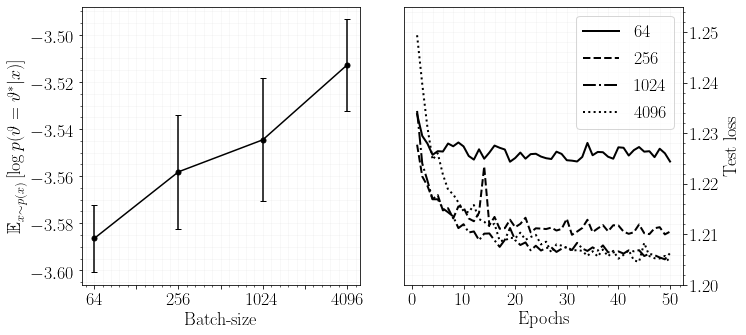

In [32]:
figure, axes = plt.subplots(ncols=2, figsize=(11, 5))

batch_sizes = [64, 256, 1024, 4096]
batch_sizes = [64, 256, 1024, 4096]

# Expectation
ax = axes[0]
ax.set_xlabel("Batch-size")
#ax.set_xscale("log", basex=2)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(["64", '', "256", '', "1024", "", "4096"])
ax.set_ylabel(r"$\mathbb{E}_{x\sim p(x)}\left[\log p(\vartheta = \vartheta^*\vert x)\right]$")

expectations_m = [m_64, m_256, m_1024, m_4096]
expectations_e = [1 * s_64, 1 * s_256, 1 * s_1024, 1 * s_4096]
ax.errorbar([1, 3, 5, 7], expectations_m, expectations_e, capsize=3, color="black", marker='o', markersize=5, linestyle="solid")
ax.grid(True, alpha=.1, which="both")
#ax.set_title(r"Expected log posterior probability of $\vartheta^*$")
ax.minorticks_on()
make_square(ax)

# Losses
ax = axes[1]
ax.set_xlabel("Epochs")
ax.set_ylabel("Test loss")
ax.grid(True, alpha=.1, which="both")
ax.minorticks_on()
markers = ['solid', 'dashed', 'dashdot', 'dotted']
for index in range(len(test_losses_m)):
    loss = test_losses_m[index]
    error = 1 * test_losses_e[index] # 95 %
    ax.plot(epochs, loss, lw=2, color="black", linestyle=markers[index], label=batch_sizes[index])
    #ax.fill_between(epochs, loss - error, loss + error, alpha=.1, lw=2, color="black")
ax.set_ylim([1.20, 1.255])
ax.legend()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xticks([0, 10, 20, 30, 40, 50])
make_square(ax)

figure.tight_layout()
plt.savefig("plots/batch-size-evaluation.pdf", bbox_inches="tight")
figure.show()